In [ ]:
import torch
from torch import nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


                  Date        Open         Low       Close   Adj Close  \
High                                                                     
537.760010  2015-06-26  537.260010  531.349976  531.690002  531.690002   
528.609985  2015-06-29  525.010010  520.539978  521.520020  521.520020   
526.250000  2015-06-30  526.020020  520.500000  520.510010  520.510010   
525.690002  2015-07-01  524.729980  518.229980  521.840027  521.840027   
524.650024  2015-07-02  521.080017  521.080017  523.400024  523.400024   

             Volume  
High                 
537.760010  2109100  
528.609985  1937800  
526.250000  2235600  
525.690002  1961000  
524.650024  1235900  


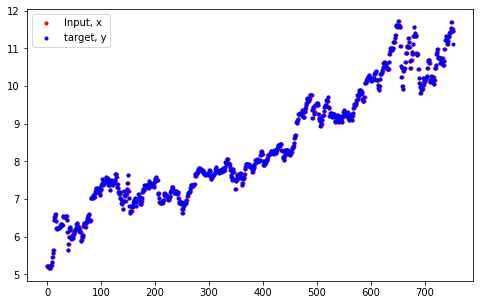

In [ ]:

goog=pd.read_csv('goog.csv', index_col=2)
data = Variable(torch.Tensor(goog.iloc[1:,2].values))

print(goog.head(5))
plt.figure(figsize=(8,5))

# how many time steps/data pts are in one batch of data
seq_length = len(data)

# generate evenly spaced data pts
x = data[:-1]/100 # all but the last piece of data
y = data[1:]/100 # all but the first

Xt=x.numpy()
Yt=y.numpy()

tt=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
# display the data
plt.plot( Xt,'r.', label='Input, x') # x
plt.plot( Yt, 'b.', label='target, y') # y

plt.legend(loc='best')
plt.show()


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()

        self.hidden_dim = hidden_dim

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)

        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)

        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)

        # get final output
        output = self.fc(r_out)

        return output, hidden



In [ ]:
# test that dimensions are as expected
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=10, n_layers=2)

# generate evenly spaced, test data pts
print('Length of data:',len(data))
data=data.view(-1,1)
print('Shape of data: ',data.shape)

test_input = data.unsqueeze(0) # give it a batch_size of 1 as first dimension


print('Input size: ', test_input.size())

# test out rnn sizes
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

####
# decide on hyperparameters
input_size=1
output_size=1
hidden_dim=32
n_layers=1

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)

###########
# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)


Length of data: 754
Shape of data:  torch.Size([754, 1])
Input size:  torch.Size([1, 754, 1])
Output size:  torch.Size([754, 1])
Hidden state size:  torch.Size([2, 1, 10])


Loss:  64.48712158203125


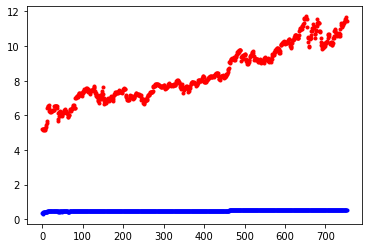

Loss:  1.3460091352462769


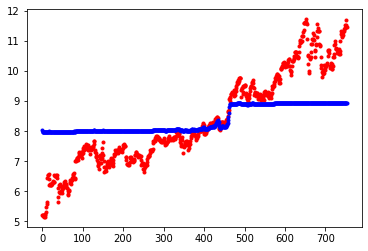

Loss:  0.0925871804356575


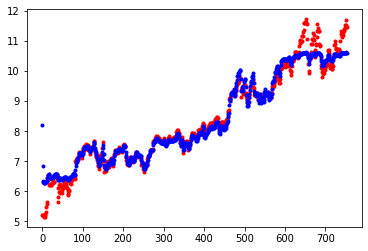

Loss:  0.02653828077018261


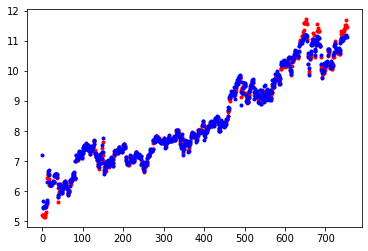

Loss:  0.01822037249803543


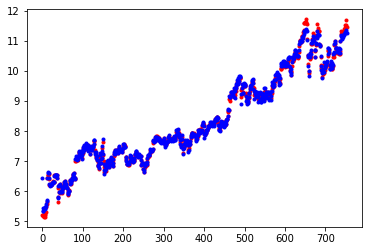

Loss:  0.015943042933940887


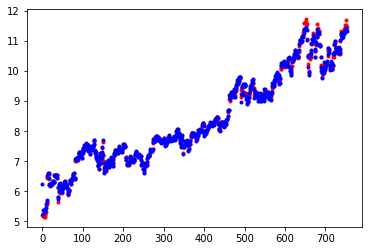

Loss:  0.014903106726706028


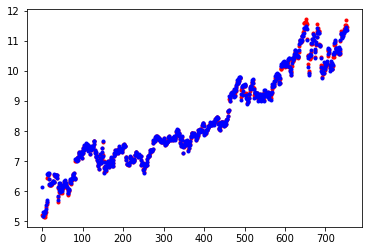

Loss:  0.014250402338802814


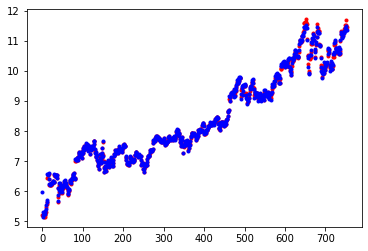

Loss:  0.013618649914860725


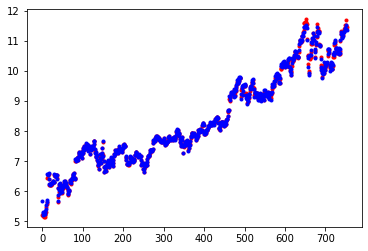

Loss:  0.013237785547971725


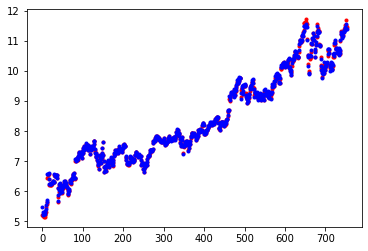

Loss:  0.013043010607361794


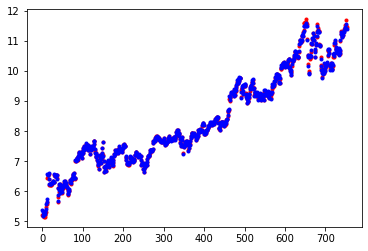

Loss:  0.013698101975023746


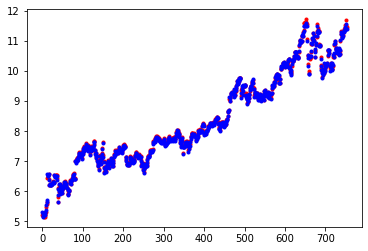

Loss:  0.012865261174738407


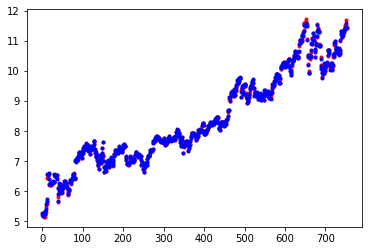

Loss:  0.012805302627384663


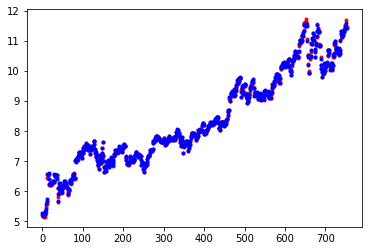

In [ ]:

# train the RNN
def train(rnn, n_steps, print_every):
    # initialize the hidden state
    hidden = None

    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data
        x = data[:-1]/100
        y = data[1:]/100

        # convert data into Tensors

        x_tensor = x.unsqueeze(0)  # unsqueeze gives a 1, batch_size dimension
        y_tensor = y

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if batch_i % print_every == 0:
            print('Loss: ', loss.item())
            xx= x.numpy()

            plt.plot( xx, 'r.')  # input
            plt.plot( prediction.data.numpy().flatten(), 'b.')  # predictions
            plt.show()

    return rnn

n_steps = 2000
print_every = 150

trained_rnn = train(rnn, n_steps, print_every)